# Project 2: Continuous Control
### Test 1 - MADDPG model

<sub>Uirá Caiado. November 07, 2018<sub>

#### Abstract

_In this notebook, I will use the Unity ML-Agents environment to train a MADDPG model for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)._


## 1. What we are going to test

We begin by checking if the necessary packages are presented. If the code cell below returns an error, please check if you have all the packages required in the README of this project.

In [1]:
%load_ext version_information
%version_information numpy, unityagents, torch, matplotlib, pandas, statsmodels

/Users/ucaiado/anaconda/envs/drlnd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Software versions
Python 3.6.6 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.0.1
OS Darwin 17.7.0 x86_64 i386 64bit
numpy 1.15.0
unityagents (prompt-toolkit 2.0.7 (/Users/ucaiado/anaconda/envs/drlnd/lib/python3.6/site-packages), Requirement.parse('prompt-toolkit<2.0.0,>=1.0.0'), {'jupyter-console'})
torch 0.4.0
matplotlib 2.2.3
pandas 0.23.4
statsmodels 0.9.0
Wed Nov 07 01:33:37 2018 -02

Now, let's define some meta variables to use in this notebook

In [2]:
import os
fig_prefix = 'figures/2018-11-07-'
data_prefix = '../data/2018-11-07-'
s_currentpath = os.getcwd()

Finally, let's import some of the necessary packages for this experiment.

In [3]:
import sys
import os
import eda
sys.path.append("../")  # include the root directory as the main
import pandas as pd
import numpy as np

## 2. Exploring the Environment

The environment used for this project is the Reacher environment, from [Unity](https://youtu.be/heVMs3t9qSk). Bellow, we are going to start this environment.

In [4]:
from drlnd import make, MADDPG, MADDPG_PARAMS

In [5]:
env = make()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the brain we will be controlling from Python.

In [6]:
# get the default brain
env.brain_name
brain = env.brain

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Let's check some information about the environment below.

In [7]:
# reset the environment
states = env.reset()

# number of agents
print('Number of agents:', env.num_agents)

# size of each action
print('Size of each action:', env.action_size)

# examine the state space 
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 3. Training the Agent

Let's use the Python API to control the agent and receive feedback from the environment.The idea is to make the agent use its experience to gradually choose better actions when interacting with the environment. First, lest's check the agent's parameters.

In [8]:
print(MADDPG_PARAMS)

                               DDPG PARAMETERS                                
BATCH_SIZE                        200   LR_CRITIC                        0.001
BUFFER_SIZE                    100000   TAU                              0.001
GAMMA                            0.99   UPDATE_EVERY                         2
LR_ACTOR                       0.0001   WEIGHT_DECAY                    0.0001


Now, we are going to train the agent for 1000 episodes or until it reaches an average score of 30 over the last 100 episodes and over the 20 agents. 

In [ ]:
%%time
from collections import deque
import pickle
import torch

episodes = 10000
rand_seed = 0

scores = []
scores_std = []
scores_avg = []
scores_window = deque(maxlen=100)

agent = MADDPG(env.state_size, env.action_size, env.num_agents, rand_seed)

SOLVED = False

print('\nNN ARCHITECURES:')
for ii in range(len(agent)):
    print('agent %i:' % (ii + 1))
    print(agent[ii].actor_local)
    print(agent[ii].critic_local)
    print('\n')

print('\nTRAINING:')
for episode in range(episodes):
    states = env.reset()
    score = np.zeros(len(agent))
    for i in range(1000):
        actions = agent.act(states, add_noise=True)
        next_states, rewards, dones = env.step(actions)
        agent.step(states, actions, rewards, next_states, dones)
        score += rewards
        states = next_states
        if np.any(dones):
            break
    scores.append(np.max(score))
    scores_window.append(np.max(score))
    scores_avg.append(np.mean(scores_window))
    scores_std.append(np.std(scores_window))
    s_msg = '\rEpisode {}\tAverage Score: {:.3f}\tσ: {:.3f}\tScore: {:.3f}'
    print(s_msg.format(episode, np.mean(scores_window),
                       np.std(scores_window), np.max(score)), end="")
    if episode % 100 == 0:
        print(s_msg.format(episode, np.mean(scores_window),
                           np.std(scores_window), np.max(score)))
    if np.mean(scores_window) >= 0.5:
        SOLVED = True
        s_msg = '\n\nEnvironment solved in {:d} episodes!\tAverage '
        s_msg += 'Score: {:.3f}\tσ: {:.3f}'
        print(s_msg.format(episode, np.mean(scores_window),
                           np.std(scores_window)))
        # save the models
        s_name = agent.__name__
        s_aux = '%scheckpoint-%s.%s.%i.pth'
        for ii in range(len(agent)):
            s_actor_path = s_aux % (data_prefix, s_name, 'actor', ii)
            s_critic_path = s_aux % (data_prefix, s_name, 'critic', ii)
            torch.save(agent[ii].actor_local.state_dict(), s_actor_path)
            torch.save(agent[ii].critic_local.state_dict(), s_critic_path)
        break

# save data to use later
if not SOLVED:
    s_msg = '\n\nEnvironment not solved =/'
    print(s_msg.format(episode, np.mean(scores_window),
          np.std(scores_window)))
print('\n')
d_data = {'episodes': episode,
          'scores': scores,
          'scores_std': scores_std,
          'scores_avg': scores_avg,
          'scores_window': scores_window}
s_aux = '%ssim-data-%s.data'
pickle.dump(d_data, open(s_aux % (data_prefix, agent.__name__), 'wb'))


NN ARCHITECURES:
agent 1:
Actor(
  (fc1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=52, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


agent 2:
Actor(
  (fc1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=52, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)



TRAINING:
Episode 0	Average Score: 0.000	σ: 0.000	Score: 0.000
Episode 100	Average Score: 0.003	σ: 0.015	Score: 0.000
Episode 200	Average Score: 0.002	σ: 0.013	Score: 0.000
Episode 300	Av

## 4. Results

The agent using the MADDPG model was able to solve the Reacher environment in 1500 episodes of 1000 steps, each.

In [ ]:
import pickle

d_data = pickle.load(open('%ssim-data-%s.data' % (data_prefix, agent.__name__), 'rb'))
s_msg = 'Environment solved in {:d} episodes!\tAverage Score: {:.2f} +- {:.2f}'
print(s_msg.format(d_data['episodes'], np.mean(d_data['scores_window']), np.std(d_data['scores_window'])))

Now, let's plot the rewards per episode. In the right panel, we will plot the rolling average score over 100 episodes $\pm$ its standard deviation, as well as the goal of this project (30+ on average over the last 100 episodes).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

#recover data
na_raw = np.array(d_data['scores'])
na_mu = np.array(d_data['scores_avg'])
na_sigma = np.array(d_data['scores_std'])

# plot the scores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# plot the sores by episode
ax1.plot(np.arange(len(na_raw)), na_raw)
ax1.set_xlim(0, len(na_raw)+1)
ax1.set_ylabel('Score')
ax1.set_xlabel('Episode #')
ax1.set_title('raw scores')

# plot the average of these scores
ax2.axhline(y=30., xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
ax2.plot(np.arange(len(na_mu)), na_mu)
ax2.fill_between(np.arange(len(na_mu)), na_mu+na_sigma, na_mu-na_sigma, facecolor='gray', alpha=0.1)
ax2.set_ylabel('Average Score')
ax2.set_xlabel('Episode #')
ax2.set_title('learning curve')

f.tight_layout()

In [ ]:
f.savefig(fig_prefix + '%s-learning-curve.jpg' % agent.__name__, format='jpg')

In [15]:
env.close()

## 5. Conclusion

The MADDPG agent was able to solve the environment in 258 episodes ...

In [42]:
import pandas as pd

def extract_info(s, d_data):
    return {'model': s,
            'episodes': d_data['episodes'],
            'mean_score': np.mean(d_data['scores_window']),
            'std_score': np.std(d_data['scores_window'])}

l_data = [extract_info(s, d) for s, d in zip(['PPO with actor/critic', 'DDPG'],
                                       [d_ppo, d_ddpg])]

df = pd.DataFrame(l_data)
df.index = df.model
df.drop('model', axis=1, inplace=True)
print(df.sort_values(by='episodes'))


                       episodes  mean_score  std_score
model                                                 
PPO with actor/critic       258   30.075059   3.739798
DDPG                        309   30.058814   2.517842


Finally, let's plot the learning curve from both agents.

In [18]:
import pickle

d_ddpg= pickle.load(open('../data/2018-10-07-sim-data-DDPG.data', 'rb'))
d_ppo = pickle.load(open('../data/2018-10-22-sim-data-PPO.data', 'rb'))

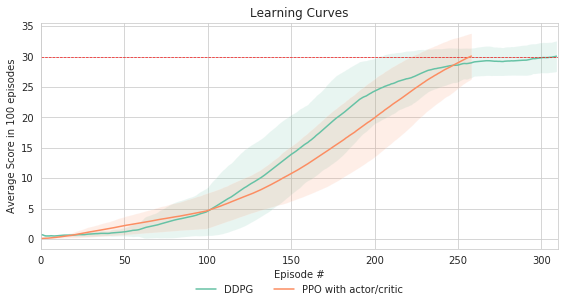

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

def recover_data(d_data):
    #recover data
    na_raw = np.array(d_data['scores'])
    na_mu = np.array(d_data['scores_avg'])
    na_sigma = np.array(d_data['scores_std'])
    return na_raw, na_mu, na_sigma

# plot the scores
f, ax2 = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)


for  s_model, d_data in zip(['DDPG', 'PPO with actor/critic'], [d_ddpg, d_ppo]):

    na_raw, na_mu, na_sigma = recover_data(d_data)
    if s_model == 'PPO with actor/critic':
        ax2.set_xlim(0, 310)
        # plot the average of these scores
        ax2.axhline(y=30., xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
    ax2.plot(np.arange(len(na_mu)), na_mu, label=s_model)
    ax2.fill_between(np.arange(len(na_mu)), na_mu+na_sigma, na_mu-na_sigma, alpha=0.15)

# format axis
ax2.legend()
ax2.set_title('Learning Curves')
ax2.set_ylabel('Average Score in 100 episodes')
ax2.set_xlabel('Episode #')

# Shrink current axis's height by 10% on the bottom
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                  box.width, box.height * 0.9])

# Put a legend below current axis
lgd = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
                 fancybox=False, shadow=False, ncol=2)
lgd.get_frame().set_linewidth(0.0)

f.tight_layout()

In [36]:
f.savefig(fig_prefix + 'final-comparition.jpg', format='jpg',
          bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=1200)